**<h4> About the Data: </h4>**
> The dataset provides a plethora of information needed to assess health insurance claims. Factors including age, gender, Body Mass Index (BMI), blood pressure, diabetic status, number of children, region, smoking status and claim amounts are contained in the data.






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt
import warnings

# For training models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
# Read in the insurance claim dataset
insurance = pd.read_csv('/content/drive/MyDrive/Personal Project/Dataset/insurance_data.csv')
insurance.head(10)

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01
5,5,6,NaN,male,34.4,96,Yes,0,No,northwest,1137.47
6,6,7,NaN,male,37.3,86,Yes,0,No,northwest,1141.45
7,7,8,19.0,male,41.1,100,No,0,No,northwest,1146.80
8,8,9,20.0,male,43.0,86,No,0,No,northwest,1149.40
9,9,10,30.0,male,53.1,97,No,0,No,northwest,1163.46


**<h4> 1. Cleaning and Prepping the Dataset: </h4>**

In [ ]:
# Check out how big it is
insurance.shape

(1340, 11)

In [ ]:
# Check types of columns, this will give us a clue as to corrupt or missing data
insurance.dtypes

index              int64
PatientID          int64
age              float64
gender            object
bmi              float64
bloodpressure      int64
diabetic          object
children           int64
smoker            object
region            object
claim            float64
dtype: object

In [ ]:
# Locating the missing values
insurance.isnull().sum()

index            0
PatientID        0
age              5
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           3
claim            0
dtype: int64

In [ ]:
# Column Age and Region has missing values. Let's drop them:
insurance = insurance.dropna()

# Double-check
insurance.isna().sum()
insurance.duplicated().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0       False
1       False
7       False
8       False
9       False
        ...  
1335    False
1336    False
1337    False
1338    False
1339    False
Length: 1332, dtype: bool>

In [ ]:
# Drop irrelevant columns:
insurance.drop(['index','PatientID'], axis=1, inplace = True)
# How much smaller did we get?
insurance.shape

(1332, 9)

In [ ]:
# For column diabetic, change Yes/No to Diabetic/Non-diabetic
insurance['diabetic'] = insurance['diabetic'].replace({'Yes':'Diabetic', 'No':'Non-diabetic'})

# For column smoker, change Yes/No to Smoker/Non-smoker
insurance['smoker'] = insurance['smoker'].replace({'Yes':'smoker', 'No':'Non-smoker'})

# Organize ages into generational groups
age_range = [13, 28, 46, 58, 61]
labels = ['Gen Z', 'Millenials', 'Gen X', 'Baby Boomers']
insurance['age_group'] = pd.cut(insurance['age'], age_range, labels = labels)
ageGroup = insurance[['age_group', 'claim']].groupby('age_group').mean().sort_values(by="claim", ascending = True)

# Categorize BMI ranges into different health status
bmi_range = [15.5, 18.5, 24.9, 29.9, 60]
labels = ['Underweight', 'Healthy', 'Overweight', 'Obese']
insurance['bmi_group'] = pd.cut(insurance['bmi'], bmi_range, labels = labels)
bmiGroup = insurance[['bmi_group', 'claim']].groupby('bmi_group').mean().sort_values(by="claim", ascending = True)

# Categorize blood pressure ranges to different blood level
blood_range = [71, 120, 129, 139, 148]
labels = ['Normal Blood Pressure', ' Elevated Blood Pressure', 'Hypertension Stage 1', 'Hypertension Stage 2']
insurance['bloodpressure_group'] = pd.cut(insurance['bloodpressure'], blood_range, labels = labels)
bloodpressureGroup = insurance[['bloodpressure_group', 'claim']].groupby('bloodpressure_group').mean().sort_values(by="claim", ascending = True)

In [ ]:
# Cleansed Dataframe
insurance.head()

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim,age_group,bmi_group,bloodpressure_group
0,39.0,male,23.2,91,Diabetic,0,Non-smoker,southeast,1121.87,Millenials,Healthy,Normal Blood Pressure
1,24.0,male,30.1,87,Non-diabetic,0,Non-smoker,southeast,1131.51,Gen Z,Obese,Normal Blood Pressure
7,19.0,male,41.1,100,Non-diabetic,0,Non-smoker,northwest,1146.80,Gen Z,Obese,Normal Blood Pressure
8,20.0,male,43.0,86,Non-diabetic,0,Non-smoker,northwest,1149.40,Gen Z,Obese,Normal Blood Pressure
9,30.0,male,53.1,97,Non-diabetic,0,Non-smoker,northwest,1163.46,Millenials,Obese,Normal Blood Pressure


**<h4> 2. Data Visualization and Analysis: </h4>**

In [ ]:
# Overview of the dataset
insurance[['age', 'bmi', 'bloodpressure', 'claim']].describe()

,age,bmi,bloodpressure,claim
count,1332.000000,1332.000000,1332.000000,1332.000000
mean,38.086336,30.658333,94.189189,13325.246426
std,11.112804,6.118967,11.445173,12109.620712
min,18.000000,16.000000,80.000000,1121.870000
25%,29.000000,26.200000,86.000000,4760.157500
50%,38.000000,30.350000,92.000000,9412.965000
75%,47.000000,34.725000,99.000000,16781.327500
max,60.000000,53.100000,140.000000,63770.430000


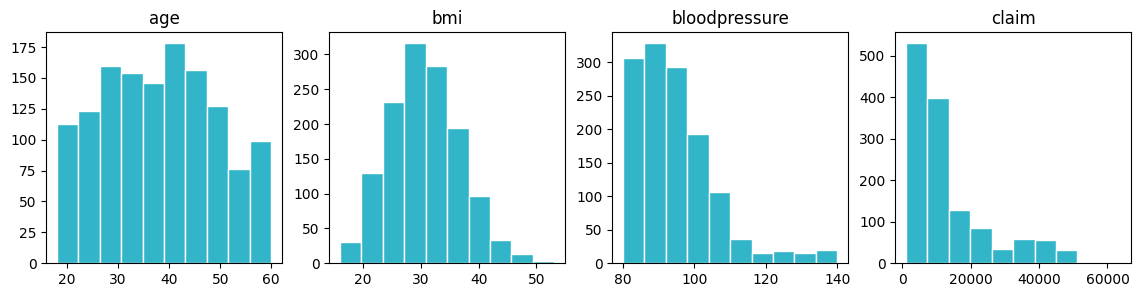

In [ ]:
# Histograms for numerical variables (Age, BMI, Bloodpressure and Claim)
fig, axes = plt.subplots(1, 4, figsize=(14,3))
age = insurance.age.hist(ax=axes[0], color="#32B5C9", ec="white", grid=False).set_title('age')

bmi = insurance.bmi.hist(ax=axes[1], color="#32B5C9", ec="white", grid=False).set_title('bmi')

bloodpressure = insurance.bloodpressure.hist(ax=axes[2], color="#32B5C9", ec="white", grid=False).set_title('bloodpressure')

claim = insurance.claim.hist(ax=axes[3], color="#32B5C9", ec="white", grid=False).set_title('claim')

**Comment:**

> The dataset reveals that the average BMI is approximately 30, suggesting that the majority of individuals fall within the overweight to obesity range. However, it is worth noting that the maximum value in the BMI column is 53, indicating the presence of outliers that have influenced the mean calculation.

> Similar observations can be made for the blood pressure and claim amount variables. The substantial difference between their mean and maximum values suggests a right-skewed distribution, further implying the presence of significant outliers within the data.

**<h5> a) BMI vs Other Factors: </h5>**

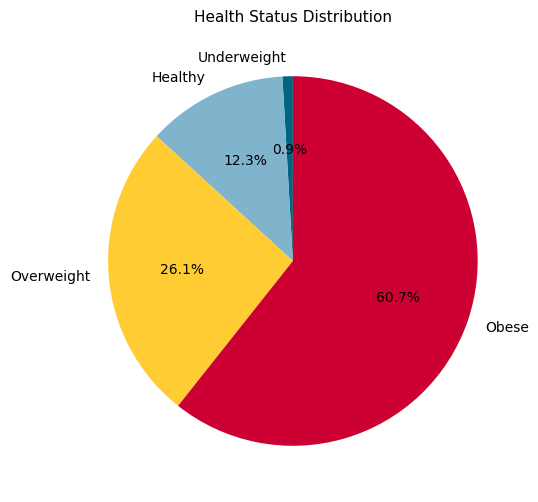

In [ ]:
# Pie chart of Heath status distribution
chart = insurance.groupby(['bmi_group'])['bmi'].sum()
fig, ax = plt.subplots(figsize=(6, 6))
colors = [(0.0, 0.4, 0.5), (0.5, 0.7, 0.8), (1.0, 0.8, 0.2), (0.8, 0.0, 0.2)] # list of colors
ax.pie(chart, labels=chart.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Add a title to the pie chart
ax.set_title('Health Status Distribution', fontsize=11)

# Show the plot
plt.show()

**Comment:**
> Interestingly, more than half of the population falls within the category "Obese", while only 12.3% of them are considered healthy.

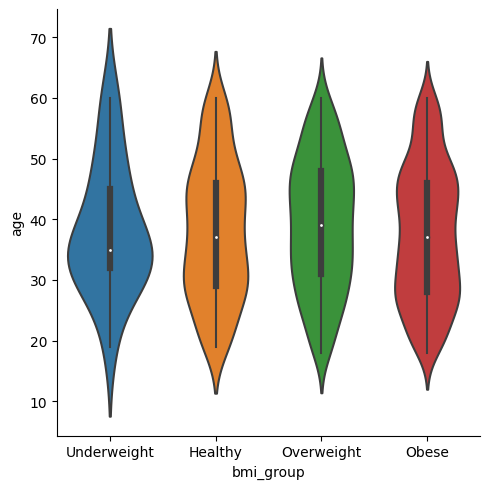

In [ ]:
# Let's consider the distribution of "age" for each BMI category:
sns.catplot(x='bmi_group', y='age', data = insurance, kind='violin')
plt.show()

**Comment:**
> Underweight and Healthy tends to be a bi-modal distribution. The peak width of Overweight is much more spread out, while the Underweight distribution is greatly right-skewed.

> Overal, the IQR of Overweight is higher compared to others.

In [ ]:
# Histogram of Total Claim Amount vs BMI Category:
claim_his = alt.Chart(insurance).mark_bar(color = 'teal').encode(
    alt.X('bmi_group:N', title='BMI Group'),
    alt.Y('claim:Q', title='Claim Amounts'),
    tooltip=[alt.Tooltip('bmi_group:N', title='BMI Group'), alt.Tooltip('claim:Q', title='Claim Amounts')]
).properties(
    title='Total Claim Amounts by BMI Category'
)

mean_line = alt.Chart(insurance).mark_rule(color='red').encode(
    y='mean(claim):Q',
    size=alt.value(2)
)

claim_his + mean_line

alt.LayerChart(...)

**Comment:**
> It's not a suprise to see that people who suffer from Obesity also has the highest claim amounts of all BMI group.

> Claim amounts for Heatlhy and Underweight group are roughly similar.

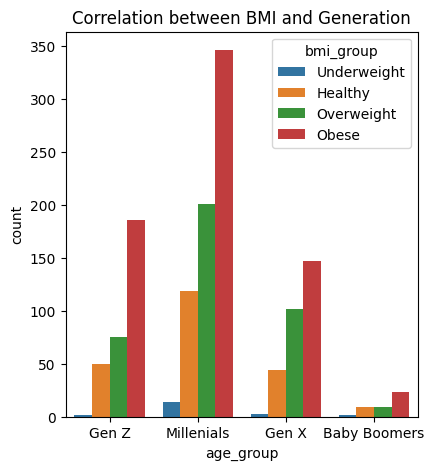

In [ ]:
# Subplot of BMI vs Generation:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Correlation between BMI and Generation")
sns.countplot(x='age_group', hue='bmi_group', data=insurance);

**Comment:**

> According to [USC Libaries](https://libguides.usc.edu/busdem/age#:~:text=Baby%20Boomers%3A%201946%20%2D%201964,%2F%20iGen%20%2F%20Centennials%201995%20%2D%202010), the following list of years are ascribed to generational age groups: Millennials (1977-1995), Gen X (1965-1976) and Baby Boomers (1946-1964).

> From the above graph, we could see that there are significantly more obesed claimants that are millenials than any other age group.

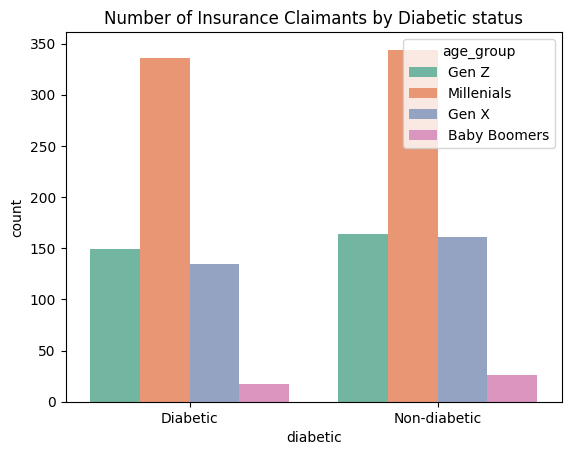

In [ ]:
# Countplot of number of Insurance Claimants by Diabetic status and Generation:
ax = sns.countplot(x='diabetic', hue='age_group', palette="Set2", data=insurance)
ax.set_title('Number of Insurance Claimants by Diabetic status')
plt.show();

**Commment:**
> While a significant number of claim recipients are diabetic, there is a very small variance between diabetic and non-diabetic across all age groups.

**<h5> b) Region & Gender vs Other Factors: </h5>**

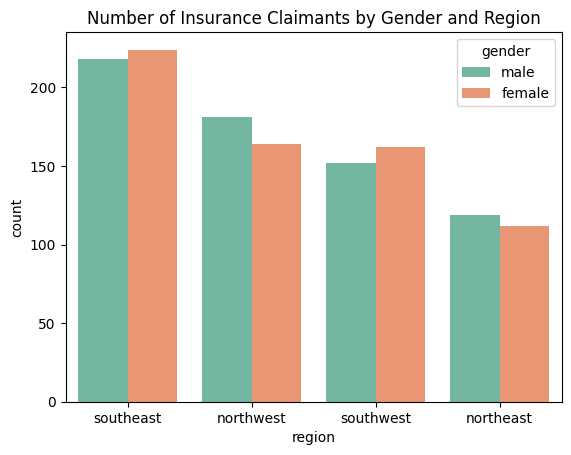

In [ ]:
# Countplot of number of Insurance Claimants by Gender and Region
ax = sns.countplot(x='region', hue='gender', palette="Set2", data=insurance)
ax.set_title('Number of Insurance Claimants by Gender and Region')
plt.show()

**Comment:**
> The plot shows that Southeast has the highest claim amounts. Besides, while the claims amount for female is higher in Southeast, and Southwest, claim amounts for males is higher in Northwest and Northeast

> Throughout the U.S, millennial males and females received a higher proportion of claims than any other age group. While a significant number of claim recipients are diabetic, there is a very small variance between diabetic and non-diabetic across all age groups.

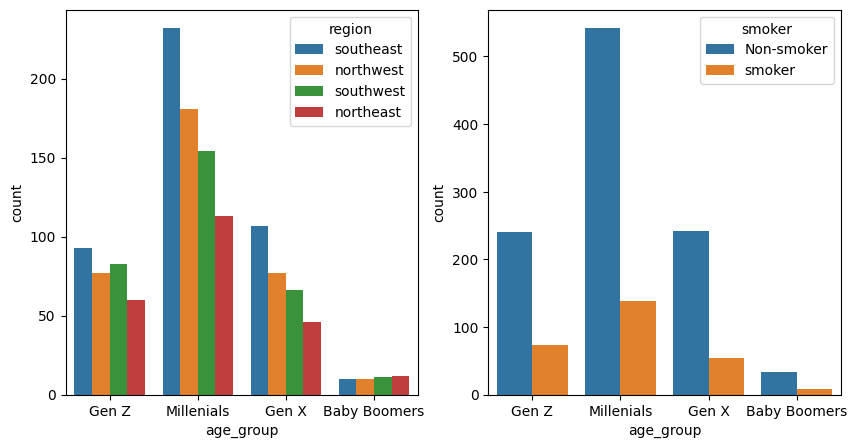

In [ ]:
# Subplot of Region vs Age Group:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.countplot(x = 'age_group', hue = 'region', data = insurance);

# Subplot of Smoking status vs Age Group
plt.subplot(1,2,2)
sns.countplot( x = 'age_group', hue = 'smoker', data = insurance);

**Comment:**
> Based on the graph, Millenials received the majority of health insurance claims, and most of the claim recipients are non-smokers.

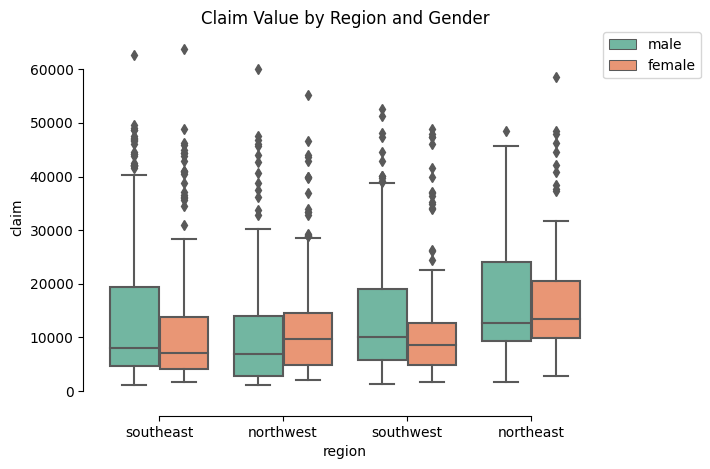

In [ ]:
# Box plot of Claim Value by Gender & Region
sns.boxplot(x='region', y = 'claim', hue = 'gender', palette = 'Set2', data = insurance).set(title = 'Claim Value by Region and Gender')
sns.despine(offset=10, trim = True)
plt.legend(bbox_to_anchor=(1.02,1), loc = 'best', borderaxespad = 0);

**Comment:**
> The plot reveals that claim median value lies in the range of around 10,000-15,000 for all the regions and genders.
> Claim value outliers are also rampant for all the regions and genders.

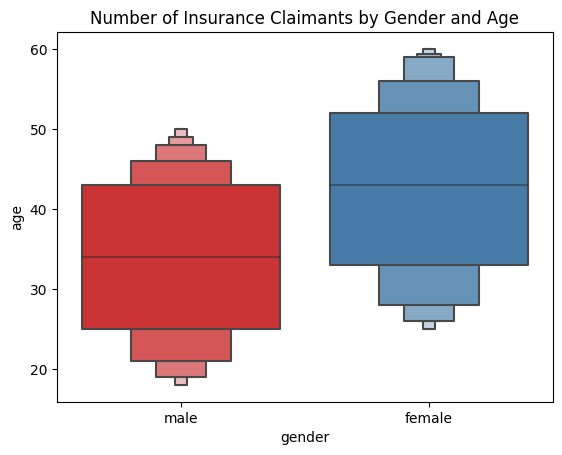

In [ ]:
# Boxplot of Gender vs Age of insurance claimants:
sns.boxenplot(x='gender', y='age', palette="Set1", data=insurance).set(title='Number of Insurance Claimants by Gender and Age');

**Commment:**
> The plot shows that the age of female insurance claimants has larger median than males, indicating that their ages are higher.

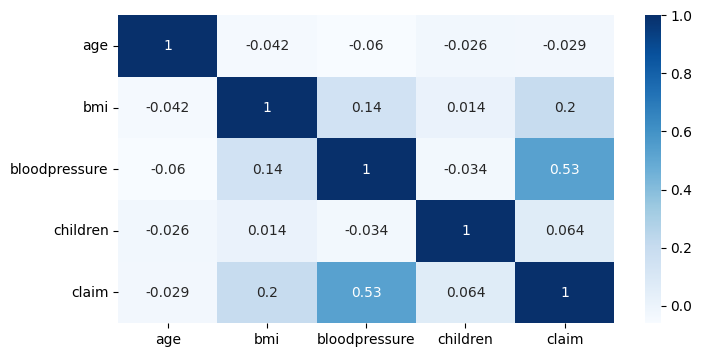

In [ ]:
# Correlation matrix between different factors
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(8, 4))
    sns.heatmap(insurance.corr(), cmap='Blues', annot=True)
    plt.show()

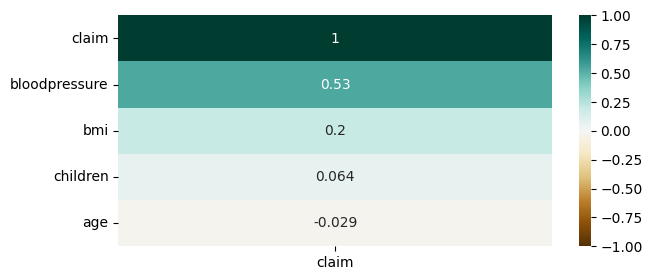

In [ ]:
# Heatmap of correlation between claim amount and other factors
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Heatmap of correlation between claim amount and other factors
    plt.figure(figsize=(7, 3))
    sns.heatmap(insurance.corr()[['claim']].sort_values(by='claim', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    plt.show()

**Comment:**
> It's easy to see that of all the factors, bloodpressure strongly correlates to claim amount, indicating that it is one of the main reason leading to high claim amounts for patients.

**<h5> c) Conclusion: </h5>**
> Patients in the Southeast have significantly more claims than any other region, which mainly comes from millennials. Obesity is a prevalent factor among claim recipients. This should be of great concern as millennials are parents to the majority of children currently under 18 years old. If this pattern continues, future generations will be prone to obesity, which can result in perpetual illness and excessive medical costs.

> According to the [CDC](https://www.cdc.gov/healthyschools/nutrition/school_nutrition_education.htm), 40 to 50 hours of nutritional education per year are needed to positively affect behavior change. Currently U.S. students receive less than 8 hours of nutritional education each year. School administrators and teachers have the ability to literally shape the future. Opportunities to teach healthy lifestyles are abundant in all grades. Teaching math by counting fruits and vegetables, planting school gardens and introducing tasty healthy food options in the cafeteria are just a few ways that children can be taught to eat to live instead of living to eat.

> Besides, state and local government officials should coordinate with school administrators to ensure schools have the needed resources to teach healthy eating habits. Teachers should enlist the help of their students when creating lessons that center on healthy lifestyles. Additionally, some activities and events can be structured to include the entire family. These actions will put millennials and their children on track to better health outcomes.

**<h4> 3. Model Training: </h4>**
> **<h5> a) Preparing Data for Modeling: </h5>**

In [ ]:
# Now, we will do some data modeling, evaluation, and some price predictions
# The first step is to split the data into categorical and numerical data
cat_df = insurance[['gender', 'diabetic', 'children', 'smoker', 'region']]
num_df = insurance[['age', 'bmi', 'bloodpressure', 'claim']]

In [ ]:
# Label encoding
le = LabelEncoder()
cat_df = insurance.select_dtypes(exclude=['int','float'])
for i in cat_df:
  cat_df[i] = le.fit_transform(insurance[i])

num_df = insurance.select_dtypes(include=['int','float'])
cleansed = pd.concat([num_df,cat_df], axis = 1)
cleansed.head()

,index,PatientID,age,bmi,bloodpressure,children,claim,gender,diabetic,smoker,region,age_group,bmi_group,bloodpressure_group
0,0,1,39.0,23.2,91,0,1121.87,1,0,0,2,3,0,3
1,1,2,24.0,30.1,87,0,1131.51,1,1,0,2,2,1,3
2,2,3,NaN,33.3,82,0,1135.94,1,0,0,2,4,1,3
3,3,4,NaN,33.7,80,0,1136.40,1,1,0,1,4,1,3
4,4,5,NaN,34.1,100,0,1137.01,1,1,0,1,4,1,3


In [ ]:
# Locating the missing values
cleansed.isnull().sum()

index                  0
PatientID              0
age                    5
bmi                    0
bloodpressure          0
children               0
claim                  0
gender                 0
diabetic               0
smoker                 0
region                 0
age_group              0
bmi_group              0
bloodpressure_group    0
dtype: int64

In [ ]:
# Column Age has missing values. Let's drop them:
cleansed = cleansed.dropna()

# Double-check
cleansed.isna().sum()
cleansed.duplicated().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0       False
1       False
7       False
8       False
9       False
        ...  
1335    False
1336    False
1337    False
1338    False
1339    False
Length: 1335, dtype: bool>

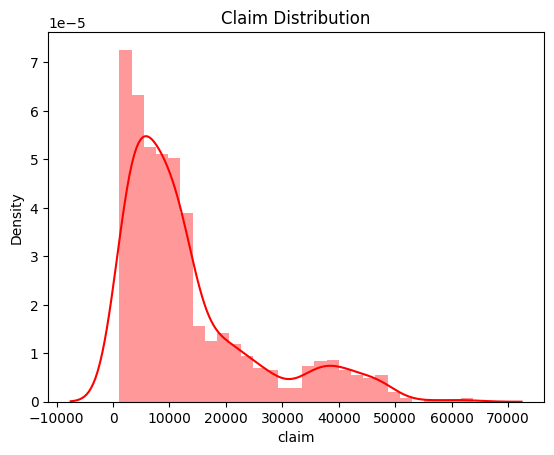

In [ ]:
# Univariate analysis to check "claim" feature before training
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.distplot(cleansed.claim, color='r', kde = True).set(title = 'Claim Distribution')

**Comment:**
> The claim distribution is greatly right-skewed. There's also some outliers exist on the lower sides, so we will try to remove them in the next step.


In [ ]:
# Remove the outliers from claim distribution
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Q1 = np.percentile(cleansed['claim'], 25, interpolation = 'midpoint')
    Q3 = np.percentile(cleansed['claim'], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    print("Old Shape: ", cleansed.shape)

    upper = np.where(cleansed['claim'] >= (Q3+1.5*IQR)) # Identify upper and lower outliers
    lower = np.where(cleansed['claim'] <= (Q1-1.5*IQR))

    cleansed.drop(upper[0], inplace = True)
    cleansed.drop(lower[0], inplace = True)

    print('New Shape: ', cleansed.shape)

Old Shape:  (1332, 12)
New Shape:  (1198, 12)


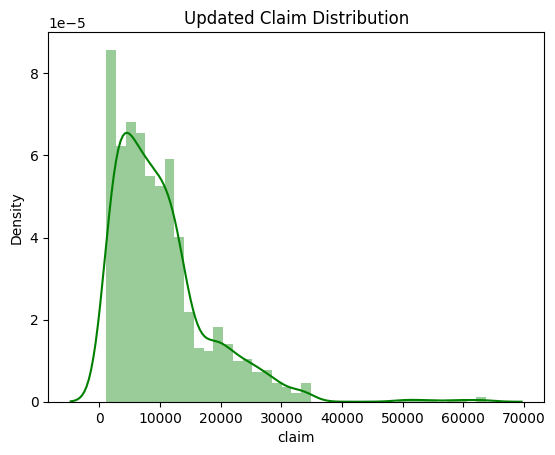

In [ ]:
# Re-running the univariate analysis on the updated "claim"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.distplot(cleansed.claim, color="g", kde=True).set(title='Updated Claim Distribution')

**<h5> b) Data Modeling: </h5>**

In [ ]:
# Segregating the Dependent Variables in X and Independent Variable in Y
X = cleansed.drop(columns=["claim"])
y = cleansed["claim"]

# Standardize the price data values to avoid biased outcome
scaler = StandardScaler()
x_scaled=scaler.fit_transform(X)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_scaled ,y, test_size=0.2, random_state=0)

# Function to fit the models (Linear Regression, Decision Tree, Random Forest, KNN)
model_preds = []

def fit_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = round(r2_score(y_test, y_pred),4)
    adj_r2 = round(1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1),4)
    mse = round(mean_squared_error(y_test, y_pred),4)
    mae = round(mean_absolute_error(y_test, y_pred),4)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),4)
    model_preds.append([model_name, r2, adj_r2, mse, mae, rmse])
    print ("The R-Squared Value is: ", r2)
    print ("Adjusted R-Squared Value is: ", adj_r2)
    print("The Mean Squared error (MSE) is: ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Error (MAE) is: ", mae)

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
fit_model(lr_model, "Linear Regression")

The R-Squared Value is:  0.5141
Adjusted R-Squared Value is:  0.5096
The Mean Squared error (MSE) is:  37403854.2163
Root Mean Squared Error (RMSE):  6115.869
Mean Absolute Error (MAE) is:  4193.8094


In [ ]:
# Decision Tree
dectree_model = DecisionTreeRegressor()
fit_model(dectree_model, "Decision Tree Regressor")

The R-Squared Value is:  0.41
Adjusted R-Squared Value is:  0.4045
The Mean Squared error (MSE) is:  45416062.1314
Root Mean Squared Error (RMSE):  6739.144
Mean Absolute Error (MAE) is:  4832.7417


In [ ]:
# Random Forest
randfor_model = RandomForestRegressor()
fit_model(randfor_model, "Random Forest Regressor")

The R-Squared Value is:  0.6495
Adjusted R-Squared Value is:  0.6462
The Mean Squared error (MSE) is:  26976366.7088
Root Mean Squared Error (RMSE):  5193.8778
Mean Absolute Error (MAE) is:  3862.1922


In [ ]:
# XG Boost
XGB_model = xgb.XGBRFRegressor()
fit_model(XGB_model, "XG Boost")

The R-Squared Value is:  0.6484
Adjusted R-Squared Value is:  0.6451
The Mean Squared error (MSE) is:  27067453.3784
Root Mean Squared Error (RMSE):  5202.6391
Mean Absolute Error (MAE) is:  3832.78


In [ ]:
# KNN
knn_model = KNeighborsRegressor(n_neighbors=6)
fit_model(knn_model, "K-Neigbors Regressor")

The R-Squared Value is:  0.4472
Adjusted R-Squared Value is:  0.4421
The Mean Squared error (MSE) is:  42551434.4483
Root Mean Squared Error (RMSE):  6523.1461
Mean Absolute Error (MAE) is:  4468.5302


**Comment**:
> Of all the training models, XGBoost appears to outperform Random Forest:
<ul type="disc">
  <li> R-square values, XGBoost has a higher value (0.7726) compared to Random Forest (0.7456), indicating that XGBoost explains more of the variance in the target variable.</li>

  <li> Mean square error (MSE), XGBoost has a lower value (15166761.8287) compared to Random Forest (16968283.2569), suggesting that XGBoost's predictions have less overall error compared to Random Forest.</li>

  <li> Similarly, a lower root mean squared error (RMSE) and mean absolute error (MAE) of XGBoost also indicates that the model has better accuracy in predicting the target variable than Random Forest</li>



> Some of the possible reasons why XGBoost performs better than Random Forest could be:
<ul type="disc">
  <li> Nonlinear relationships: XGBoost maybe better at capturing nonlinear relationships between features and the target variable, such as age, BMI, blood pressure, and the number of children. These variables may have complex interactions and nonlinear effects on the insurance claim amount, and XGBoost's ability to model such relationships could result in improved performance.</li>


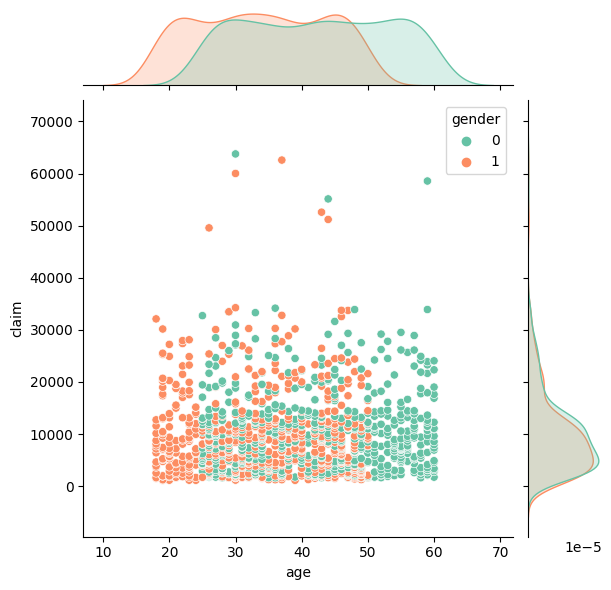

In [ ]:
# For example, consider the relationship between Claim Amounts vs Age of Claimants
sns.jointplot(data=cleansed, x="age", y="claim", hue="gender", palette="Set2")
plt.show() # Due to complex interactions or nonlinearity present in the data, XGBoost's ability to handle suck complexities is better

> Other possible reasons why XGBoost performs better than Random Forest could be:
<ul type="disc">
  <li> Gradient Boosting: XGBoost's gradient boosting approach allows it to iteratively learn from mistakes made by previous weak models. This iterative learning process can be beneficial when there are complex patterns and dependencies in the data, potentially improving the model's ability to predict insurance claims accurately.</li>
  <li> Outlier robustness: Though some outliers have been removed, there might still be influential data points or extreme values that can affect the performance of Random Forest more than XGBoost. XGBoost's gradient-based approach can be more robust to outliers, allowing it to handle such instances more effectively. </li>

**<h5> c) Model Evaluation: </h5>**

In [ ]:
# Function to evaluate model
def model_eval():
    preds = pd.DataFrame(model_preds)
    preds.columns = ["MODEL", "R2", "ADJ_R2", "MSE", "RMSE", "MAE"]
    return preds.sort_values(by="R2", ascending=False)

model_eval()

,MODEL,R2,ADJ_R2,MSE,RMSE,MAE
2,Random Forest Regressor,0.6495,0.6462,2.697637e+07,3862.1922,5193.8778
3,XG Boost,0.6484,0.6451,2.706745e+07,3832.7800,5202.6391
0,Linear Regression,0.5141,0.5096,3.740385e+07,4193.8094,6115.8690
4,K-Neigbors Regressor,0.4472,0.4421,4.255143e+07,4468.5302,6523.1461
1,Decision Tree Regressor,0.4100,0.4045,4.541606e+07,4832.7417,6739.1440


**<h5> c) Price Predictions: </h5>**

In [ ]:
# Training the Model
modelETR = XGBRFRegressor()
modelETR.fit(X_train, y_train)

# Predict the model with test data
y_pred = modelETR.predict(X_test)

In [ ]:
output = pd.DataFrame({'Actual_Price':y_test,'Predicted_Price':y_pred})
result = cleansed.merge(output,left_index = True, right_index = True)

result[['PatientID', 'age', 'gender', 'Actual_Price', 'Predicted_Price']].sample(25)

,PatientID,age,gender,Actual_Price,Predicted_Price
538,539,49.0,0,7418.52,8341.520508
1134,1135,36.0,0,24671.66,12368.702148
359,360,46.0,0,4949.76,7633.476074
195,196,33.0,0,3056.39,7659.055176
955,956,30.0,0,14133.04,7200.574219
277,278,26.0,1,4076.50,7213.683594
392,393,58.0,0,5385.34,6653.653809
1039,1040,39.0,0,18804.75,8319.892578
765,766,26.0,0,10923.93,11615.758789
1098,1099,58.0,0,21880.82,21256.771484


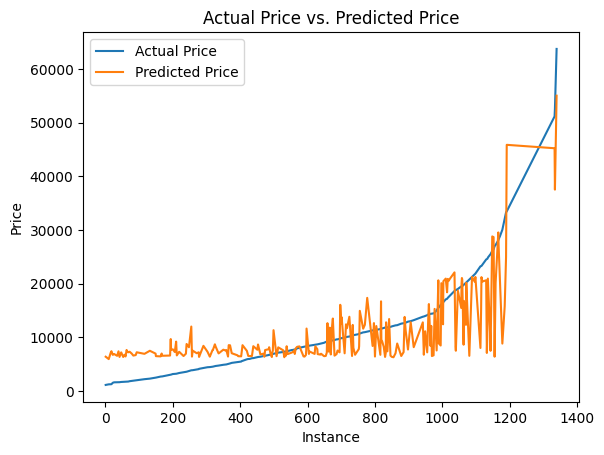

In [ ]:
plt.plot(result['Actual_Price'], label='Actual Price')
plt.plot(result['Predicted_Price'], label='Predicted Price')
plt.xlabel('Instance')
plt.ylabel('Price')
plt.title('Actual Price vs. Predicted Price')
plt.legend()
plt.show()

**Comment:**
> Though XGBoost performs the best of all the models, the difference between the predicted and actual prices are still noticeably high, indicating there's still room for improvement.

> One of the possible reasons for this significance difference could be because the R-squared is still low considering all 4 models (roughly 0.65). An acceptable R-squared should be between 0.5 to 0.99, and an R-squared of 0.65 means that approximately 65% of the variance in the predicted prices can be explained by the features included in the model.